In [2]:
import sys

sys.path.append('/Users/dashiell/workspace/simplex-score-matching/src')

from ssm.simplex_proj import vector_simplex_proj
from ssm.visualize_simplex import rotate_simplex_to_xy
import ssm.aitchison as aitch

from sympy import symbols, exp, ln
from sympy.matrices import Matrix

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(45)


/Users/dashiell/miniconda3/envs/ssm/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [279]:
import jax.random as jrandom
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

def v(p):
    alpha = jnp.ones((p.shape[-1],))
    return -1. * (alpha * jnp.log(p)).sum()


def drift_potential(t, x, args):
    xmax = jnp.max(x)
    x = x / xmax
    p = jax.nn.softmax(x)
    alphas = jnp.ones((p.shape[-1],))
    num_alphas = alphas.sum()
    return -1 * aitch.simplex_metric_tensor_inv(
        p,
        (num_alphas * p) - alphas
    )


def diffusion(t, x, args):
    p = jax.nn.softmax(x)
    jac = jax.jacobian(jax.nn.softmax)(p)
    return 2 * jac
    
    



def do_sde(x0, num_steps, key):
    #ilr, ilr_inv = aitch.make_isometric_transforms(x.shape[-1])
    #x0 = ilr(x)
    min_noise, max_noise = 0.5, 5
    #key, *subkeys1 = jax.random.split(key, num_steps + 1)
    #key, *subkeys2 = jax.random.split(key, num_steps + 1)
    noise = jax.random.normal(key, (num_steps, x0.shape[-1]))
    # schedule = get_noise_schedule(min_noise, max_noise, num_steps)
    #noise = noise * schedule[...,None]
    alphas = jnp.ones((x0.shape[-1],))
    alpha_total = alphas.sum()
    payoff = make_payoff_matrix(alphas)
    delta_t = 1 / num_steps
    def sde_step(x, noise):
        # noise, sigma = noise_things
        g_inv = partial(aitch.simplex_metric_tensor_inv, jax.nn.softmax(x))
        scaled_noise = g_inv(noise)
        # new_inds = maybe_permute(key1, key2, x.shape[-1])
        drift = g_inv(jnp.matmul(payoff, alpha_total * x - alphas))
        #full_sigma = jnp.sqrt(delta_t) * noise
        new_x = x - (drift * delta_t) + (2 * jnp.sqrt(delta_t) * noise)
        return new_x, new_x
    final_loc, path = jax.lax.scan(
        sde_step,
        x0,
        noise
    )


In [250]:
from diffrax.term import _ControlTerm

class SimplexControlTerm(_ControlTerm):

    
    @staticmethod
    def prod(vf, control):
        _, g_inv = jax.jvp(
            jax.nn.softmax,
            (vf, ),
            (control, )
        )
        return g_inv
    

In [229]:
t0, t1 = 0, 6
#drift = lambda t, y, args: -y
diffusion = lambda t, y, args: y
brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(3,), key=jax.random.PRNGKey(0))
terms = MultiTerm(ODETerm(drift_potential), SimplexControlTerm(diffusion, brownian_motion))
solver = Euler()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0, t1, dt0=0.01, y0=aitch.clr(jnp.array([0.9, 0.3, 0.07])), saveat=saveat)


In [230]:
sol.evaluate(7.5)

DeviceArray([-4.185115 ,  1.917137 ,  2.2679775], dtype=float32, weak_type=True)

In [290]:
from diffrax import Heun

def run_sde(x0, t1, key):
    t0 = 0
    #diffusion = lambda t, y, args: y
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(3,), key=key)
    terms = MultiTerm(ODETerm(drift_potential), ControlTerm(diffusion, brownian_motion))
    solver = Heun()
    saveat = SaveAt(ts=jnp.linspace(t0, t1, 50))
    sol = diffeqsolve(terms, solver, t0, t1, dt0=0.1, y0=aitch.clr(x0), saveat=saveat)
    return sol.ys



keys = jnp.stack(jax.random.split(key, 10000))
t1 = jnp.ones((10000,)) * 200

outs = jax.vmap(run_sde, in_axes=(None, 0, 0))(jnp.array([0.9, 0.07, 0.03]), t1, keys)


In [232]:
jax.nn.softmax(outs[10, 0:10, :])

DeviceArray([[0.90000004, 0.07      , 0.03      ],
             [0.88919276, 0.07538468, 0.03542256],
             [0.8670548 , 0.08833228, 0.04461288],
             [0.831426  , 0.11086412, 0.05770987],
             [0.7844539 , 0.13993843, 0.07560769],
             [0.7672655 , 0.14768292, 0.08505156],
             [0.7058892 , 0.18489276, 0.10921811],
             [0.68978906, 0.18910907, 0.12110193],
             [0.60068595, 0.24418622, 0.15512788],
             [0.49141514, 0.2935795 , 0.21500532]], dtype=float32)

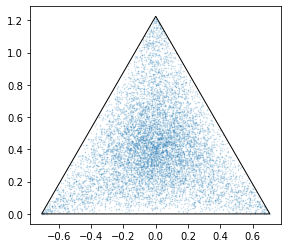

<Figure size 720x720 with 0 Axes>

In [294]:
sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])
#noised_samples = add_noise(0.8, 0.9, 3, 100_000, subkey) 

#samples = jax.random.dirichlet(subkey, jnp.array([0.1, 0.1, 0.1]), (100_000,))

plt.figure()

X = jax.vmap(rotate_simplex_to_xy)(jax.nn.softmax(outs[:, 50, :]))
plt.scatter(X[:,0], X[:,1], alpha=.2, s=.3)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.figure(figsize=(10,10))
plt.show()

In [38]:
plt.figure()

plt.plot_surface(x, y, sfm_vals)
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'plot_surface'

<Figure size 432x288 with 0 Axes>

In [23]:
s = jnp.exp(b).sum()
print(jax.nn.softmax(b))
print(jnp.exp(b))
print(jnp.exp(b) / s)
print(jnp.log(jax.nn.softmax(b)))
print(b - jnp.log(s))
print(v(jax.nn.softmax(b)))
print(3 * jnp.log(jnp.exp(b).sum()))

[0.0242889  0.48785555 0.48785555]
[0.13533528 2.7182817  2.7182817 ]
[0.0242889  0.48785558 0.48785558]
[-3.717736  -0.7177359 -0.7177359]
[-3.7177358  -0.71773577 -0.71773577]
5.153208
5.1532073


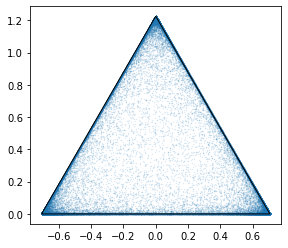

<Figure size 720x720 with 0 Axes>

In [8]:
key, subkey = jax.random.split(key)

sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])
#noised_samples = add_noise(0.8, 0.9, 3, 100_000, subkey) 

samples = jax.random.dirichlet(subkey, jnp.array([0.1, 0.1, 0.1]), (100_000,))

plt.figure()

X = jax.vmap(rotate_simplex_to_xy)(samples)
plt.scatter(X[:,0], X[:,1], alpha=.2, s=.1)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.figure(figsize=(10,10))
plt.show()